## kcb 금융 데이터 시각화 

In [1]:
#!pip install statsmodels
!pip install IPython
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
from matplotlib.ticker import IndexLocator, MaxNLocator
import matplotlib.font_manager as fm
import scipy.stats as stats
import urllib
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

fm.get_fontconfig_fonts()
font_location = './data/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name, size=15)

In [2]:
raw_data = pd.read_csv("./data/credit_card_data.csv")
# raw_data = pd.read_csv(r"C:\Users\mnch\workspace\datasciene\ml_viz\kcb\credit_card_data.csv")
raw_data = raw_data.drop(0).reset_index() # 10대 첫번째 행의 데이터 오류로 삭제 해준다.

In [3]:
# pop_cd : cd 고유번호 L011: 지역번호(01:서울, 1:10대, 022:인천20대) Y:성별번호 Y80(80대 남자) 
# year : 년도 
# month : 월 
# avg_score : 신용점수  
# avg_rat:  신용등급 
# city : 도시  
# sex : 성별 
# ages : 나이대 
# population : pop_cd로 구분된 그룹에 포함된 고객인원 수/경제활동 인구수 
# num_opencard : 카드개설 개수 
# num_usecard : 사용카드 개수 
# monthly_card_spend :  카드 소비 금액 
# monthly_lc : 대출 약정 금액  
# monthly_loan : 대출 금액 합계  
# monthly_bk_loan : 은행대출 금액  
# monthly_cd_loan : 카드대출 금액   
# monthly_installments_loan : 할부 대출 금액 
# monthly_insurance_loan : 보험 대출 금액 
# monthly_sbk_loan : 저축은행 대출 금액 
# loan_commitment : 한도 대출 금액 (마이너스 통장) 
# inst_rep_loanb : 분할 상환 대출 금액  
# ls_rep_loanb : 일시 상환 대출 금액 
# credit_loan : 카드 대출 금액 
# mortgage_loan : 담보 대출 금액 
# credit_card_payment : 신용카드 사용 금액 
# credit_card_installments_payment : 신용카드 할부 사용 금액 

In [4]:
# 시각화를 위한 새로운 변수 생성 

# 카드 활용률 = 사용카드 개수 / 카드개설 개수
raw_data['card_use_ratio'] = round(raw_data['num_usecard'] / raw_data['num_opencard'] ,2)

# 총 신용카드사용금액 = 신용카드 사용금액 + 신용카드 할부 사용 금액
raw_data['credit_total_payment'] = raw_data['credit_card_payment'] + raw_data['credit_card_installments_payment']

# 총 체크카드사용금액 = 카드 소비 금액 - 총 신용카드사용금액
raw_data['check_total_payment'] = raw_data['monthly_card_spend'] - raw_data['credit_total_payment'] 

# 신용카드 사용률 = 총 신용카드 사용 금액 /총 카드 소비 금액
raw_data['credit_use_ratio'] = raw_data['credit_total_payment'] / raw_data['monthly_card_spend']

# 체크카드 사용률 = 총 체크카드 사용 금액 / 총 카드 소비 금액
raw_data['check_use_ratio'] = raw_data['check_total_payment'] / raw_data['monthly_card_spend']

# 카드 총 사용액 (? 이 변수가 monthly_card_spend:카드 소비 금액 와의 차이는? )
raw_data['total_card'] = raw_data['monthly_card_spend'] + raw_data['credit_card_payment'] + raw_data['credit_card_installments_payment']

In [5]:
# data를 지역과 성별로 나눔
area_data = raw_data[raw_data['pop_cd'].str.contains('L')].reset_index(drop=True)
area_data = area_data.drop(columns = ['sex']) # 결측값 sex 제거

sex_data = raw_data[raw_data['pop_cd'].str.contains('Y')].reset_index(drop=True)
sex_data = sex_data.drop(columns = ['city']) #결측값 city 제거

In [6]:
area_data['avg_rat'].unique()

array([4, 2, 3], dtype=int64)

# __가설1: 수도권 및 대도시의 카드 평균 사용금액이 높을 것이다__

지역별 인구수의 차이로 사용금액의 차이가 날 것이라고 생각하였다.

<AxesSubplot:title={'center':'카드 평균 사용금액'}, xlabel='city', ylabel='monthly_card_spend'>

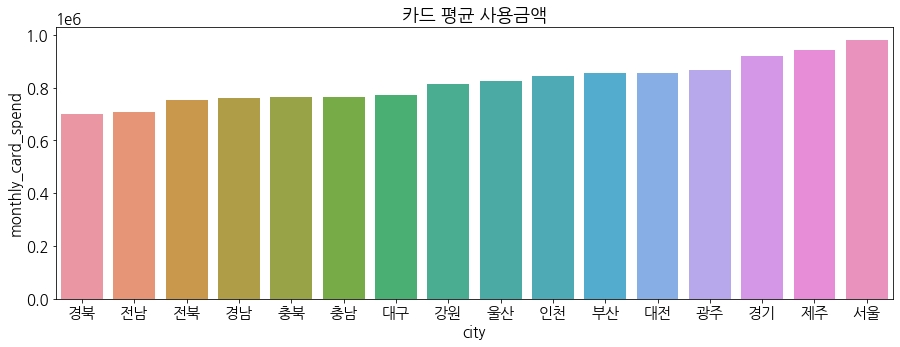

In [7]:
# 서울 경기의 평균 카드 사용금액이 높다
df = area_data[['city','population','avg_score','monthly_card_spend','monthly_loan']]
city_card = df.groupby(['city'])['monthly_card_spend'].mean().sort_values(ascending=True).reset_index(drop=False)

plt.figure(figsize=(15, 5))
plt.title('카드 평균 사용금액')
sns.barplot(x='city',y='monthly_card_spend', data=city_card)

In [8]:
city_card = df.groupby(['city'])['monthly_card_spend'].mean().reset_index(drop=False)

<AxesSubplot:xlabel='city', ylabel='population'>

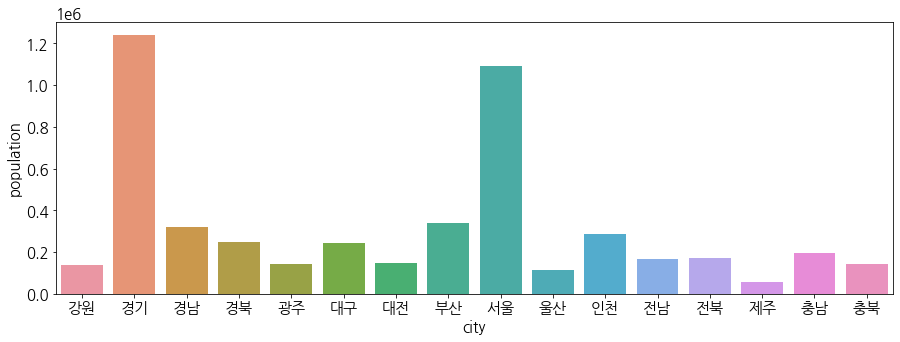

In [9]:
# 제주의 인구가 적은데 총 사용량이 높은 것을 보니 인구수 대비 총 사용량을 생각해봐야겠다.
pop_data = df[['city','population']]
pop_data = pop_data.groupby('city')['population'].mean().reset_index(drop=False)
pop_data

plt.figure(figsize=(15, 5))
sns.barplot(x='city',y='population',data=pop_data)

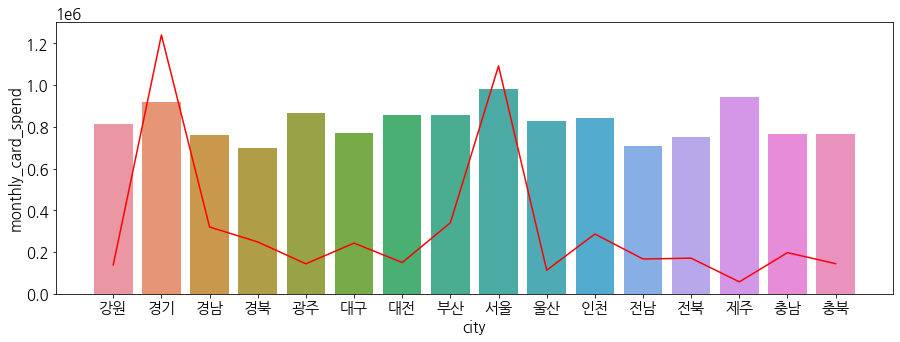

In [10]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1,1,1)

ax = sns.barplot(x='city',y='monthly_card_spend', data=city_card)
ax = sns.lineplot(x='city',y='population',data=pop_data, color='red')

인구수가 높은 경기, 서울은 카드 사용금액이 높게 나타난다.

하지만 인구수가 적은 제주, 광주에서도 카드 사용금액이 높게 나타난다. 인구와 카드 사용 금액의 상관관계를 봐야 할 것 같다.

어느정도 상관관계가 있는 것 같은데, 특정지역의 데이터 값이 다르게 나타나는 이유를 알아봐야 할 것 같다.

# 결론
### 수도권 및 대도시(ex 서울, 경기) 지역의 평균 카드 사용액이 높게 나타난다.
### 그러나 제주 지역에서 특이하게 인구수가 적음에도 불구하고 카드 사용액이 높게 나타나는 것을 볼 수 있다. 
### 그 이유는 제주 지역에 유입되는 여행객들에 의해 카드 사용액이 높게 나타나는 것 같다.

# __가설2: 지역별로 대출액의 차이로 신용도의 편차가 있을 것이다.__

지역별 관계를 보면 서울 지역의 신용도가 높은 것을 알 수 있다.

In [11]:
df.corr()

,population,avg_score,monthly_card_spend,monthly_loan
population,1.000000,-0.034749,0.472534,0.249834
avg_score,-0.034749,1.000000,-0.129758,0.601206
monthly_card_spend,0.472534,-0.129758,1.000000,0.443765
monthly_loan,0.249834,0.601206,0.443765,1.000000


<Figure size 1440x360 with 0 Axes>

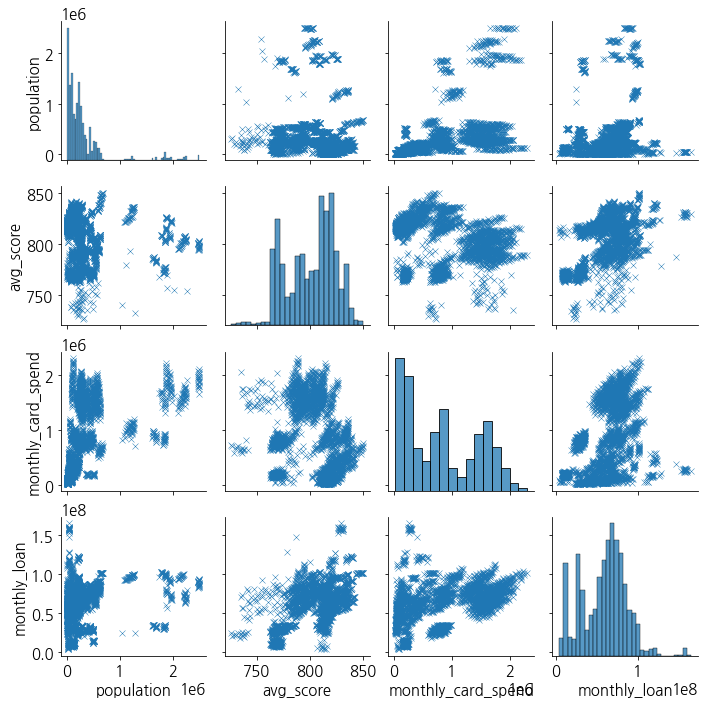

In [12]:
plt.figure(figsize=(20, 5))
sns.pairplot(data=df, markers ='x' )


<AxesSubplot:>

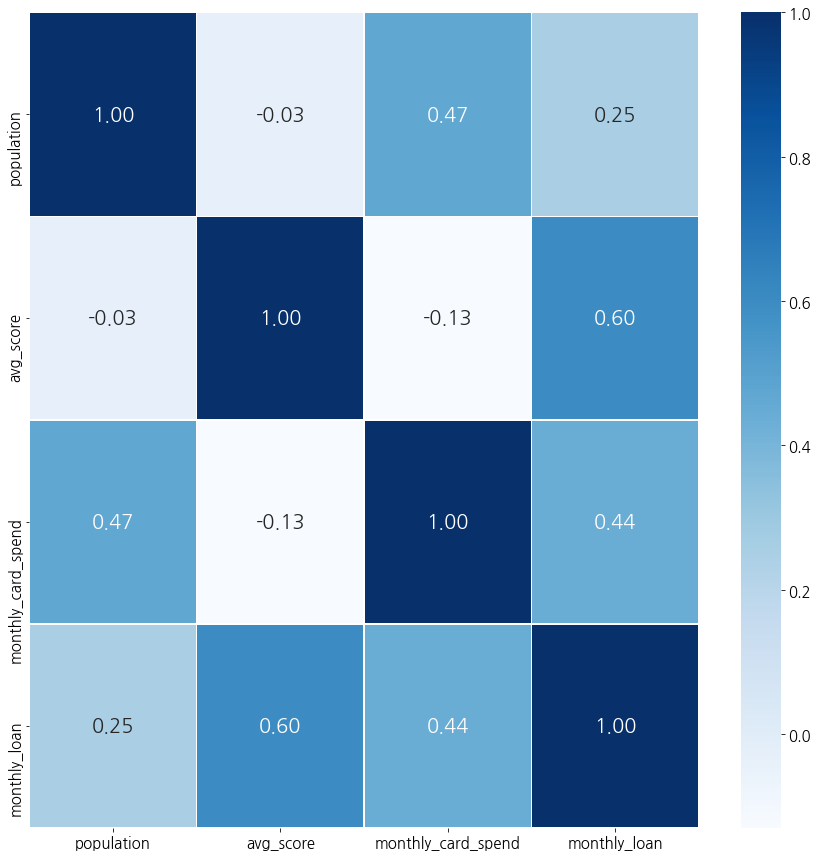

In [13]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues', annot_kws={"size": 20})

### 인구와 카드사용량 / 신용도와 대출 / 카드사용량과 대출 간에 상관관계가 있다는 것을 볼 수 있다.

(780.0, 820.0)

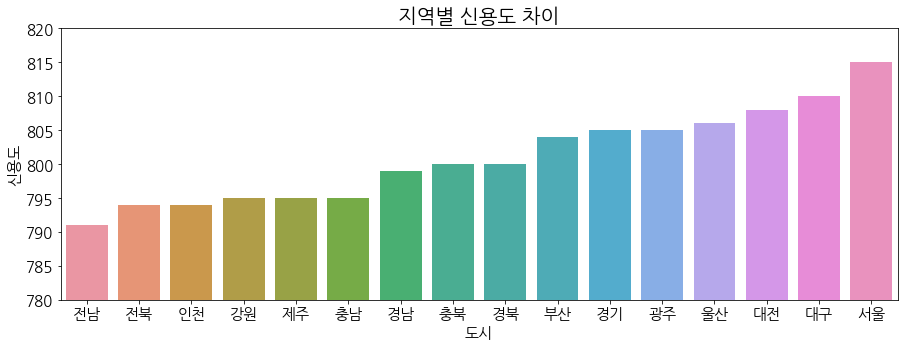

In [14]:
city_avg = round(area_data.groupby(["city"])['avg_score'].agg('mean').sort_values(ascending=True).reset_index())

plt.figure(figsize=(15,5))
sns.barplot(x='city' , y='avg_score',data=city_avg)
plt.title('지역별 신용도 차이', size=20)
plt.xlabel('도시')
plt.ylabel('신용도')
plt.ylim([780,820])

In [15]:
city_avg = round(area_data.groupby(["city"])['avg_score'].agg('mean').reset_index())

In [16]:
# 전체 인구수 비교
area_population = area_data.groupby('city')['population'].sum().reset_index()
area_population['pop_per'] = area_population['population']/area_population['population'].sum()

Text(0.5, 1.0, '지역별 인구수 비교')

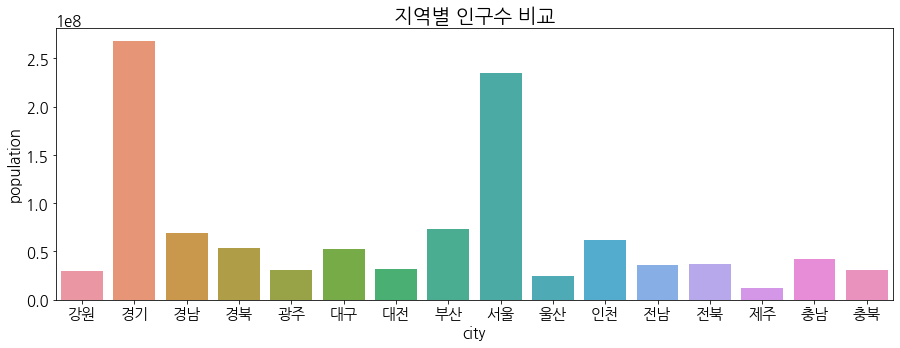

In [17]:
plt.figure(figsize=(15,5))
sns.barplot(x='city', y='population', data=area_population)
plt.title('지역별 인구수 비교', size=20)

Text(0.5, 1.0, '인구수 차이')

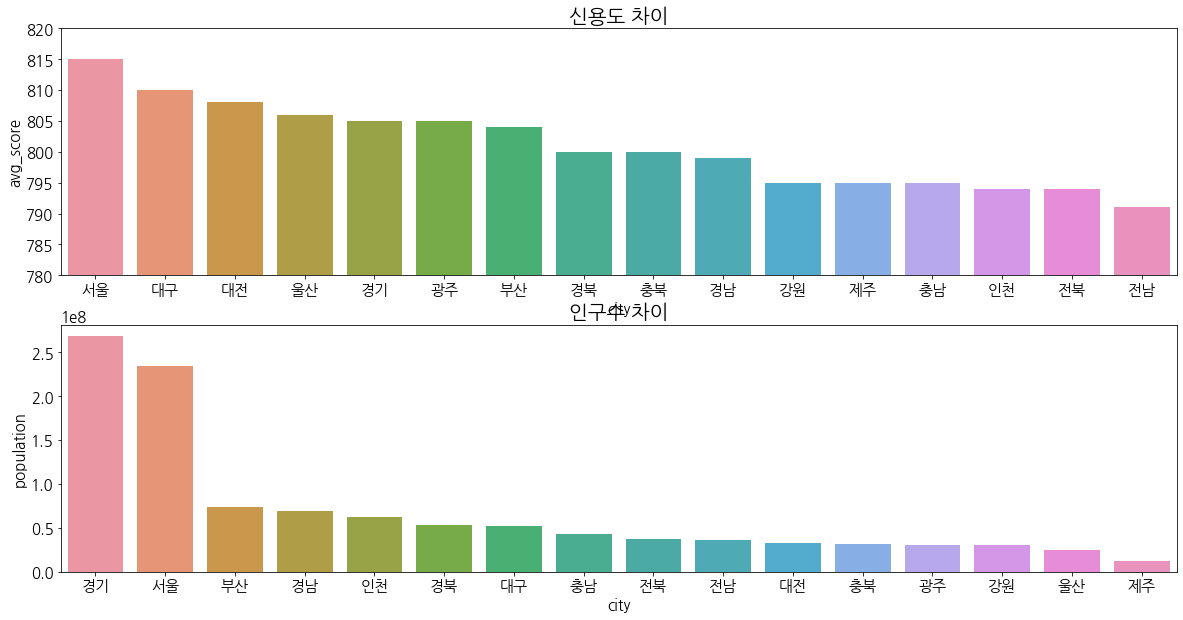

In [18]:
# 인구수와 신용도 차이 비교
city_avg = city_avg.sort_values(by='avg_score', ascending=False)
area_population = area_population.sort_values(by='population', ascending=False)

fig, ax = plt.subplots(nrows=2,figsize=(20,10))

sns.barplot(x='city' , y='avg_score',data=city_avg, ax=ax[0])
ax[0].set_ylim(780, 820)
ax[0].set_title('신용도 차이', size=20)

sns.barplot(x='city', y='population', data=area_population, ax=ax[1])
plt.title('인구수 차이', size=20)

### 인구수 TOP(서울,경기,부산) BOTTOM(전남,전북,인천) 비교해보니 인구수가 많은 지역의 평균 신용도가 높다.
### 특정 몇 지역(울산)이 인구수에 비해 신용도가 높게 측정되지만 크게 의미가 있는 것 같진 않다.

Text(0.5, 1.0, '카드 사용액 차이')

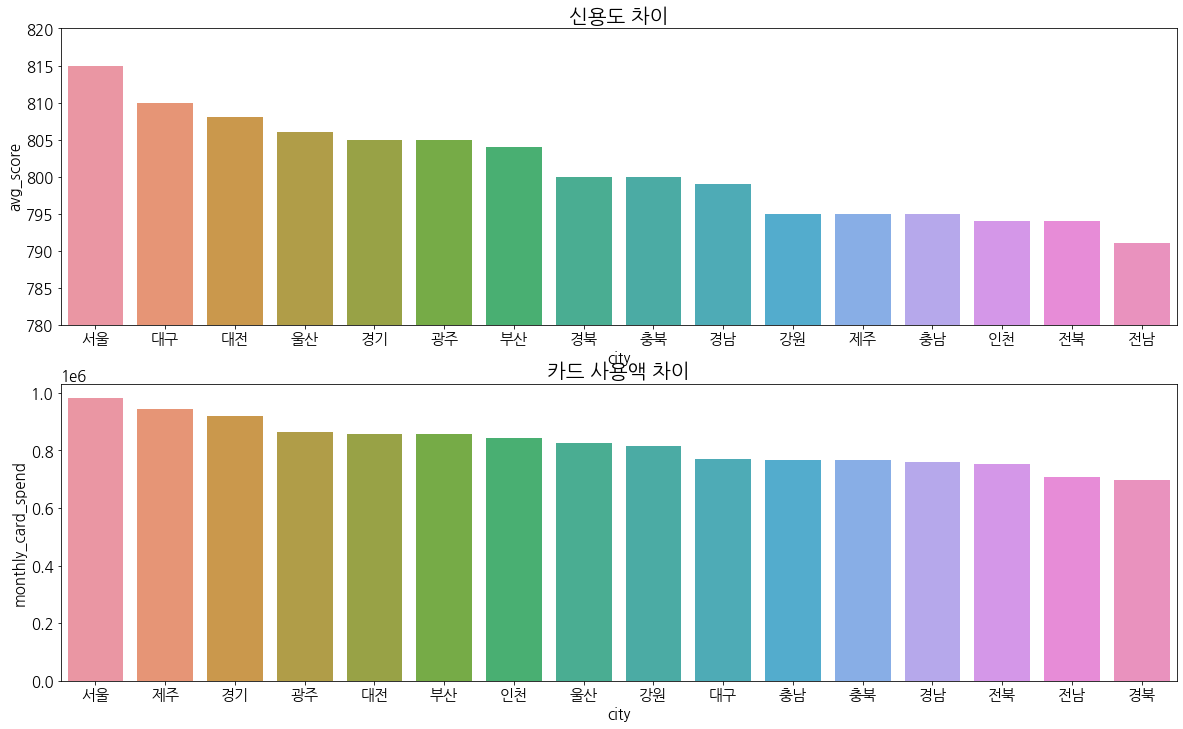

In [19]:
# 카드 사용액과 신용도 차이 비교
city_card = city_card.sort_values(by='monthly_card_spend',ascending=False)

fig, ax = plt.subplots(nrows=2,figsize=(20,12))

sns.barplot(x='city' , y='avg_score',data=city_avg, ax=ax[0])
ax[0].set_ylim(780, 820)
ax[0].set_title('신용도 차이',size=20)

sns.barplot(x='city', y='monthly_card_spend', data=city_card, ax=ax[1])
plt.title('카드 사용액 차이', size =20)

### 도시들의 비교 데이터가 대부분 비슷한 값을 보이지만 제주는 신용도와 카드 사용액에 관계가 없는 것으로 보인다.

# __가설보충: 신용도는 대출액, 카드사용액과 상관관계가 있을 것이다.__

### (신용도 - 대출) , (신용도 - 카드 사용액) , (카드사용액 - 대출) -> 상관관계 확인

## __상관계수확인__

In [20]:
df.corr() # 신용도와 대출은 서로 관계가 있다. 신용도와 카드 사용량은 관계가 적음을 알 수 있다.

,population,avg_score,monthly_card_spend,monthly_loan
population,1.000000,-0.034749,0.472534,0.249834
avg_score,-0.034749,1.000000,-0.129758,0.601206
monthly_card_spend,0.472534,-0.129758,1.000000,0.443765
monthly_loan,0.249834,0.601206,0.443765,1.000000


In [21]:
# 신용도에 따른 대출액, 월별 카드 사용량으로 구분.
avg_data = df.sort_values(by='avg_score').reset_index(drop=True)
avg_data

,city,population,avg_score,monthly_card_spend,monthly_loan
0,인천,303000,726,720000,24690000
1,부산,326000,727,710000,21180000
2,전북,199000,729,590000,22580000
3,광주,180000,731,660000,22130000
4,대구,232000,731,690000,22170000
...,...,...,...,...,...
3450,서울,660000,849,720000,101180000
3451,서울,655000,849,680000,101220000
3452,서울,670000,850,770000,101490000
3453,서울,679000,850,700000,101600000


In [22]:
# 신용도에 따른 대출 평균값
avg_loan = avg_data.groupby('avg_score')['monthly_loan'].mean().reset_index()

## 신용도 - 대출

Text(0, 0.5, '대출액')

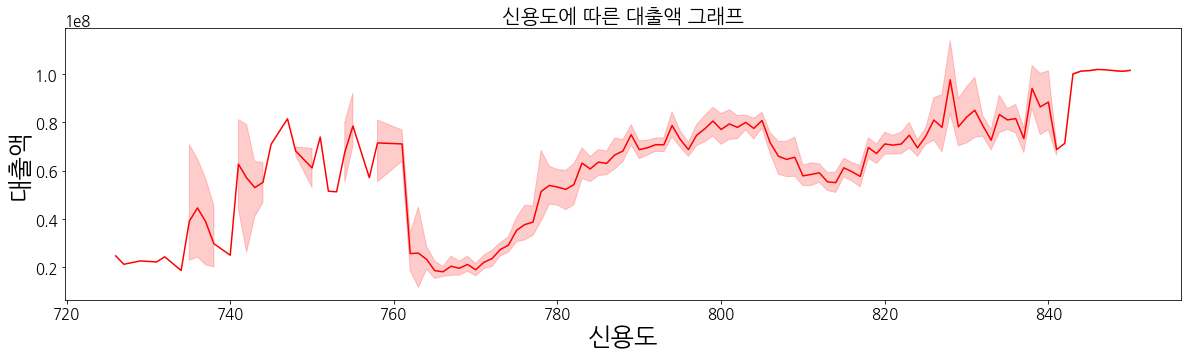

In [23]:
plt.figure(figsize=(20, 5))
sns.lineplot(x=avg_data['avg_score'],y=avg_data['monthly_loan'],data=avg_data, color='r')
plt.gca().xaxis.set_major_locator(MaxNLocator(steps=[2])) 
plt.title('신용도에 따른 대출액 그래프', size =20)
plt.xlabel('신용도', size=25)
plt.ylabel('대출액', size=25)
# 신용도 750 구간쯤 대출이 상승하는 것을 볼 수 있다. 이유는 무엇일까..

In [24]:
round(avg_loan[(avg_loan['avg_score'] >= 760) & (avg_loan['avg_score'] <= 780)])

,avg_score,monthly_loan
26,761,71080000.0
27,762,25655000.0
28,763,25797778.0
29,764,23241923.0
30,765,18540889.0
31,766,18069859.0
32,767,20378551.0
33,768,19514416.0
34,769,21131461.0
35,770,18900526.0


In [25]:
# 신용도 밀도에 따라 데이터가 누적되어 있을 수 있다고 생각했다.
result = []
for i in range(726,851):
    result.append((avg_data['avg_score'] == i).sum())
    print(i,"의 개수:", result[i-726])

726 의 개수: 1
727 의 개수: 1
728 의 개수: 0
729 의 개수: 1
730 의 개수: 0
731 의 개수: 2
732 의 개수: 1
733 의 개수: 0
734 의 개수: 1
735 의 개수: 3
736 의 개수: 4
737 의 개수: 2
738 의 개수: 3
739 의 개수: 0
740 의 개수: 1
741 의 개수: 2
742 의 개수: 3
743 의 개수: 3
744 의 개수: 2
745 의 개수: 1
746 의 개수: 0
747 의 개수: 1
748 의 개수: 2
749 의 개수: 0
750 의 개수: 4
751 의 개수: 1
752 의 개수: 1
753 의 개수: 1
754 의 개수: 2
755 의 개수: 3
756 의 개수: 0
757 의 개수: 1
758 의 개수: 3
759 의 개수: 0
760 의 개수: 0
761 의 개수: 3
762 의 개수: 8
763 의 개수: 9
764 의 개수: 26
765 의 개수: 45
766 의 개수: 71
767 의 개수: 69
768 의 개수: 77
769 의 개수: 89
770 의 개수: 76
771 의 개수: 63
772 의 개수: 43
773 의 개수: 48
774 의 개수: 41
775 의 개수: 27
776 의 개수: 19
777 의 개수: 22
778 의 개수: 14
779 의 개수: 22
780 의 개수: 13
781 의 개수: 12
782 의 개수: 18
783 의 개수: 21
784 의 개수: 29
785 의 개수: 26
786 의 개수: 41
787 의 개수: 37
788 의 개수: 36
789 의 개수: 46
790 의 개수: 39
791 의 개수: 35
792 의 개수: 61
793 의 개수: 59
794 의 개수: 51
795 의 개수: 43
796 의 개수: 35
797 의 개수: 23
798 의 개수: 23
799 의 개수: 11
800 의 개수: 18
801 의 개수: 22
802 의 개수: 33
803 의 개수: 50
804 의 개수: 33
805 의 개수: 4

Text(0.5, 1.0, '신용도 구간 인원 수')

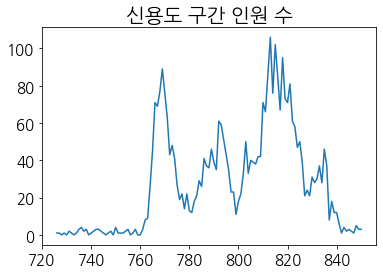

In [26]:
# 위와 같은 구간에 상승하는 것을 알 수 있다. but 800 구간에서는 수가 적지만 대출 금액이 높음을 볼 수 있다.
y = np.array(result)
x = np.arange(726,len(result)+726,1)
plt.plot(x,y)
plt.title('신용도 구간 인원 수', size=20)

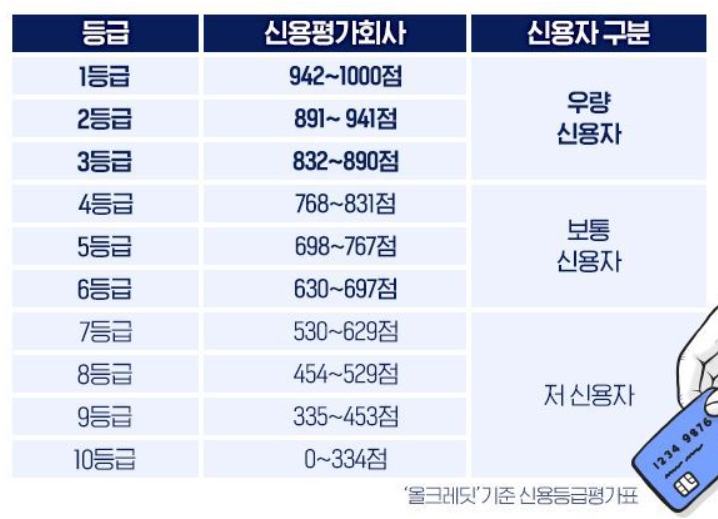

In [27]:
Image('./data/avg_score.jpg')

## 신용도 - 카드사용액

Text(0, 0.5, '카드 사용액')

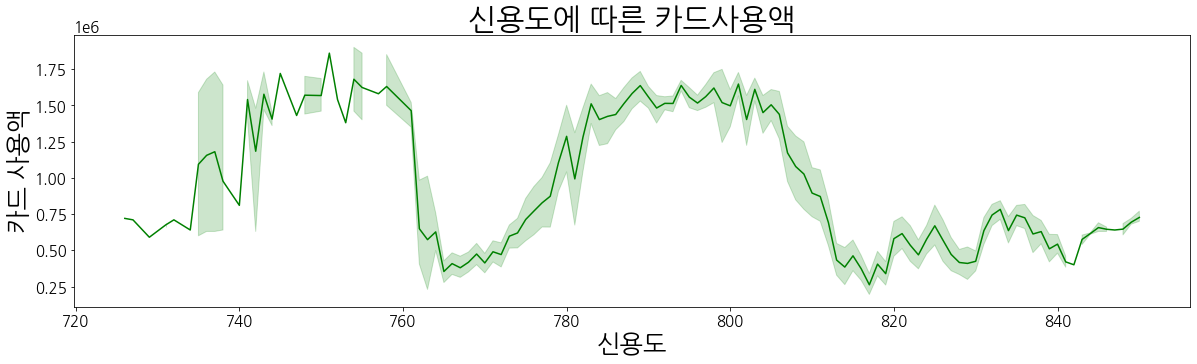

In [28]:
# 신용도와 카드 사용액의 상관관계
plt.figure(figsize=(20, 5))
sns.lineplot(x=avg_data['avg_score'],y=avg_data['monthly_card_spend'],data=avg_data, color='g')
plt.gca().xaxis.set_major_locator(MaxNLocator(steps=[2]))
plt.title('신용도에 따른 카드사용액', size =30)
plt.xlabel('신용도', size=25)
plt.ylabel('카드 사용액', size=25)

In [29]:
# 신용도별 카드 평균값
avg_card = round(avg_data.groupby('avg_score')['monthly_card_spend'].mean().reset_index())

In [30]:
avg_data

,city,population,avg_score,monthly_card_spend,monthly_loan
0,인천,303000,726,720000,24690000
1,부산,326000,727,710000,21180000
2,전북,199000,729,590000,22580000
3,광주,180000,731,660000,22130000
4,대구,232000,731,690000,22170000
...,...,...,...,...,...
3450,서울,660000,849,720000,101180000
3451,서울,655000,849,680000,101220000
3452,서울,670000,850,770000,101490000
3453,서울,679000,850,700000,101600000


In [31]:
# loan/spend 전처리
card_loan = avg_data[['monthly_card_spend','monthly_loan']].sort_values(by='monthly_card_spend',ascending=True)

## 카드 사용액 - 대출

Text(0, 0.5, '대출액')

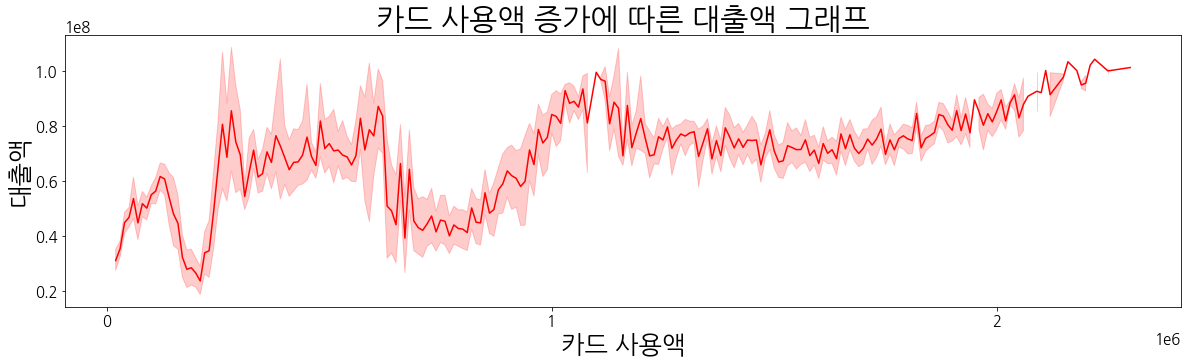

In [32]:
# 카드사용액 - 대출
plt.figure(figsize=(20, 5))
sns.lineplot(x=card_loan['monthly_card_spend'],y=card_loan['monthly_loan'],data=avg_data, color='r')
plt.gca().xaxis.set_major_locator(MaxNLocator(steps=[2]))
plt.title('카드 사용액 증가에 따른 대출액 그래프', size =30)
plt.xlabel('카드 사용액', size=25)
plt.ylabel('대출액', size=25)

### 카드 사용액이 증가함에 따라 카드 대출액도 증가하는 것을 볼 수 있다.

Text(0, 0.5, '대출액')

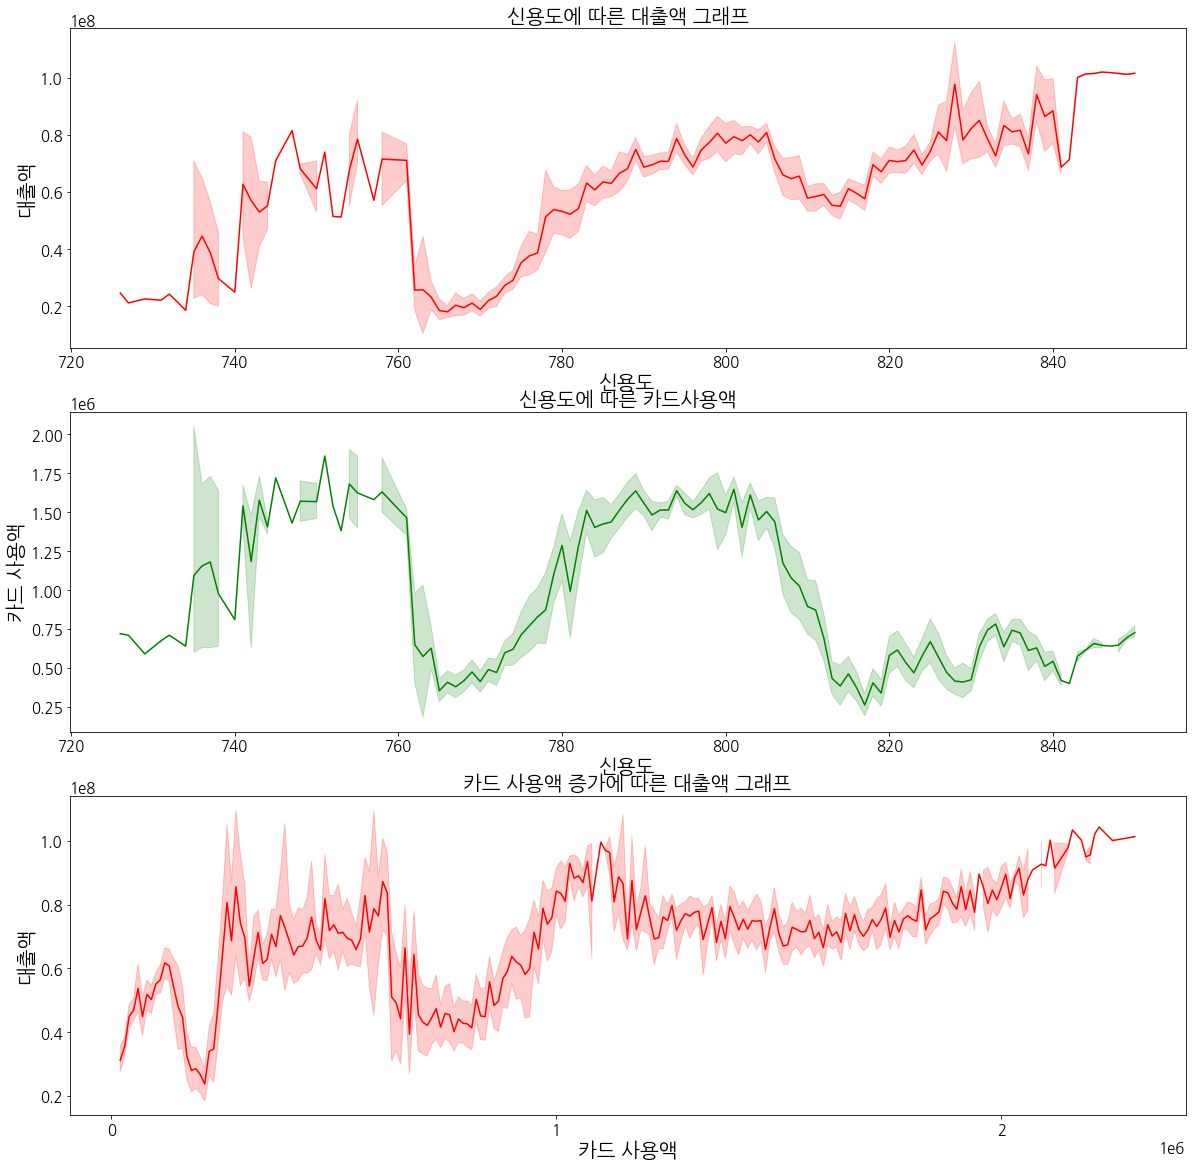

In [33]:
fig, ax = plt.subplots(nrows=3,figsize=(20,20))


sns.lineplot(x=avg_data['avg_score'],y=avg_data['monthly_loan'],data=avg_data, color='r' ,ax=ax[0])
plt.gca().xaxis.set_major_locator(MaxNLocator(steps=[2])) 
ax[0].set_title('신용도에 따른 대출액 그래프', size =20)
ax[0].set_xlabel('신용도', size=20)
ax[0].set_ylabel('대출액', size=20)

# 신용도와 카드 사용액의 상관관계

sns.lineplot(x=avg_data['avg_score'],y=avg_data['monthly_card_spend'],data=avg_data, color='g',ax=ax[1])
plt.gca().xaxis.set_major_locator(MaxNLocator(steps=[2]))
ax[1].set_title('신용도에 따른 카드사용액', size =20)
ax[1].set_xlabel('신용도', size=20)
ax[1].set_ylabel('카드 사용액', size=20)

# 카드사용액 - 대출
sns.lineplot(x=card_loan['monthly_card_spend'],y=card_loan['monthly_loan'],data=avg_data, color='r',ax=ax[2])
plt.gca().xaxis.set_major_locator(MaxNLocator(steps=[2]))
ax[2].set_title('카드 사용액 증가에 따른 대출액 그래프', size =20)
ax[2].set_xlabel('카드 사용액', size=20)
ax[2].set_ylabel('대출액', size=20)